# Classifying Iris Species
In this section, we will go through a simple machine learning application and create
our first classification model. In the process, we will introduce some core concepts and terms.

Let’s assume that a hobby botanist is interested in distinguishing the species of some
iris flowers that she has found. She has collected some measurements associated with
each iris: the length and width of the petals and the length and width of the sepals, all
measured in centimeters.

She also has the measurements of some irises that have been previously identified by
an expert botanist as belonging to the species setosa, versicolor, or virginica. For these
measurements, she can be certain of which species each iris belongs to. Let’s assume
that these are the only species our hobby botanist will encounter in the wild.

Our goal is to build a machine learning model that can learn from the measurements
of these irises whose species is known, so that we can predict the species for a new
iris.

Reference: Introduction to Machine learning with Python

## Import Data
The sklearn package provides some built-in real-world data sets to let users experience working on a real-world data analysis applications. The Iris data set is one of them. Please refer to https://scikit-learn.org/stable/datasets/index.html for more information about these built-in data sets.

In [53]:
from sklearn import datasets
import numpy as np
import pandas as pd
import scipy
import urllib
import sklearn as sns

import matplotlib.pyplot as plt
from pylab import rcParams

from sklearn import neighbors
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

np.set_printoptions(precision = 4, suppress = True)
%matplotlib inline
rcParams['figure.figsize'] = 7,4
plt.style.use('seaborn-whitegrid')




In [54]:
iris_data = datasets.load_iris()
iris_data
print("Feature names: \n", iris_data.feature_names)
print("Target names: \n", iris_data.target_names)

print("Feature data size: \n", iris_data.data.shape)
print("Target data size: \n", iris_data.target.shape)

Feature names: 
 ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target names: 
 ['setosa' 'versicolor' 'virginica']
Feature data size: 
 (150, 4)
Target data size: 
 (150,)


## Training and Testing Data

We want to build a machine learning model from this data that can predict the species
of iris for a new set of measurements. But before we can apply our model to new
measurements, we need to know whether it actually works—that is, whether we
should trust its predictions.

To assess the model’s performance, we show it new data (data that it hasn’t seen
before) for which we have labels. This is usually done by splitting the labeled data we
have collected (here, our 150 flower measurements) into two parts. One part of the
data is used to build our machine learning model, and is called the training data or
training set. The rest of the data will be used to assess how well the model works; this
is called the test data, test set, or hold-out set.

scikit-learn contains a function that shuffles the dataset and splits it for you: the
[train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) function. As default, this function extracts 75% of the rows in the data as the
training set, together with the corresponding labels for this data. The remaining 25%
of the data, together with the remaining labels, is declared as the test set. Deciding
how much data you want to put into the training and the test set respectively is somewhat
arbitrary, but using a test set containing 25% of the data is a good rule of thumb.

In scikit-learn, data is usually denoted with a capital X, while labels are denoted by
a lowercase y. This is inspired by the standard formulation f(x)=y in mathematics,
where x is the input to a function and y is the output. Following more conventions
from mathematics, we use a capital X because the data is a two-dimensional array (a
matrix) and a lowercase y because the target is a one-dimensional array (a vector).
Let’s call train_test_split on our data and assign the outputs using this nomenclature:

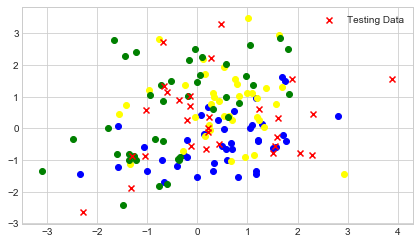

In [55]:
X, y = make_classification(n_samples=150, n_features=4, n_informative=4,
                           n_redundant=0, n_classes=3, n_clusters_per_class=1, 
                           weights=None, flip_y=0.01, class_sep=0.5, hypercube=True,
                           shift=0.0, scale=1.0, shuffle=True, random_state=None)

# Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=142)


# Visualize the generated data
colors = ['blue', 'yellow', 'green']
for i, color in enumerate(colors):
    plt.scatter(X_train[y_train == i, 0], X_train[y_train == i, 1], c=color)
plt.scatter(X_test[:, 0], X_test[:,1], c='red', marker='x', label='Testing Data')
plt.legend(loc='best')
plt.show()

Before making the split, the train_test_split function shuffles the dataset using a
pseudorandom number generator. If we just took the last 25% of the data as a test set,
all the data points would have the label 2, as the data points are sorted by the label
(see the output for iris['target'] shown earlier). Using a test set containing only
one of the three classes would not tell us much about how well our model generalizes,
so we shuffle our data to make sure the test data contains data from all classes.

To make sure that we will get the same output if we run the same function several
times, we provide the pseudorandom number generator with a fixed seed using the
random_state parameter. This will make the outcome deterministic, so this line will
always have the same outcome. We will always fix the random_state in this way when
using randomized procedures.

The output of the train_test_split function is X_train, X_test, y_train, and
y_test, which are all NumPy arrays. X_train contains 75% of the rows of the dataset,
and X_test contains the remaining 25%:

In [22]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))

X_train shape: (120, 4)
y_train shape: (120,)


In [23]:
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_test shape: (30, 4)
y_test shape: (30,)


## K-Nearest Neighbours

Now we can start building the actual machine learning model. There are many classification
algorithms in scikit-learn that we could use. Here we will use a k-nearest
neighbors classifier, which is easy to understand. Building this model only consists of
storing the training set. To make a prediction for a new data point, the algorithm
finds the point in the training set that is closest to the new point. Then it assigns the
label of this training point to the new data point.

All machine learning models in scikit-learn are implemented in their own classes,
which are called Estimator classes. The k-nearest neighbors classification algorithm
is implemented in the [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) class in the neighbors module. Before
we can use the model, we need to instantiate the class into an object. This is when we
will set any parameters of the model. The most important parameter of KNeighbors
Classifier is the number of neighbors, which we will set to 1 for our first exploration:

In [56]:
# Create and training a KNN classifier model
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

# Use the model to predict testing data
y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

To build the model on the training set, we call the fit method of the knn object,
which takes as arguments the NumPy array X_train containing the training data and
the NumPy array y_train of the corresponding training labels:

## Making Predictions

We can now make predictions using this model on new data for which we might not
know the correct labels. Imagine we found an iris in the wild with a sepal length of
5 cm, a sepal width of 2.9 cm, a petal length of 1 cm, and a petal width of 0.2 cm.
What species of iris would this be? We can put this data into a NumPy array, again by
calculating the shape—that is, the number of samples (1) multiplied by the number of
features (4):

In [35]:
X_new = np.array([[5, 2.9, 1, 0.2]])
print("X_new.shape: {}".format(X_new.shape))
X_new = X_new.reshape(1,-1)

X_new.shape: (1, 4)


Predict the result label of X_new:

In [36]:
prediction = clf.predict(X_new)
print(prediction)

[1]


Our model predicts that this new iris belongs to the class 0, meaning its species is
setosa. But how do we know whether we can trust our model? We don’t know the correct
species of this sample, which is the whole point of building the model!

## Evaluating the Model

This is where the test set that we created earlier comes in. This data was not used to
build the model, but we do know what the correct species is for each iris in the test
set. So, we can use the trained model to predict these data instances and calculate the [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) to evaluate how good the model is.

#### Checkpoint 1: 

In [59]:
accuracy = accuracy_score(y_train, y_pred_train)
print('Testing accuracy is: ', accuracy)

print('Confusion Matrix',confusion_matrix(y_train, y_pred_train))

Testing accuracy is:  0.825
Confusion Matrix [[32  3  6]
 [ 1 34  4]
 [ 1  6 33]]


# Parameter Tuning with Cross Validation (CV)

In this section, we’ll explore a CV method that can be used to tune the hyperparameter K using the above training and test data.

Scikit-learn comes in handy with its [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) method. We specifiy that we are performing 10 folds with the cv=10 parameter and that our scoring metric should be accuracy since we are in a classification setting. In each iteration, the training data take 90% of the total data while testing data takes 10%. The average on the accuracies reported from each iteration will make the testing accuracy more robust than just a single split of the data.


In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
clf = KNeighborsClassifier(n_neighbors = 10)
scores = cross_val_score(clf, X, y, cv=10)
print('Accuracy for each round: \n', scores)
print('Average accuracy: %.4f +- %.4f' % (scores.mean(), scores.std()))

Accuracy for each round: 
 [0.5333 0.8    0.7333 0.7333 0.8    0.8667 0.8667 0.9333 0.6667 0.8   ]
Average accuracy: 0.7733 +- 0.1083


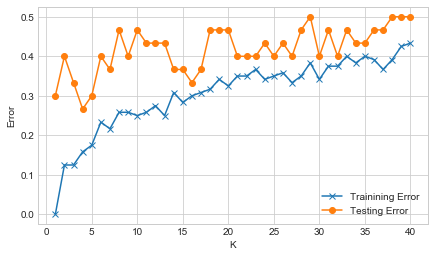

In [60]:
# Plot the accurcy trend w.r.t. K
training_error=list()
testing_error=list()

for i in range(1, 41):
    clf = KNeighborsClassifier(n_neighbors = i)
    clf.fit(X_train, y_train)
    training_error.append(1.0-accuracy_score(clf.predict(X_train), y_train))
    testing_error.append(1.0-accuracy_score(clf.predict(X_test), y_test))

# Plot the relationship
plt.plot(range(1, 41), training_error, marker='x', label='Trainining Error')
plt.plot(range(1, 41), testing_error, marker='o', label='Testing Error')
plt.xlabel('K')
plt.ylabel('Error')
plt.legend(loc='best')
plt.show()

Training Error seems to be continuously going up with some fluctuation and reaches to maximum value when K is 40. When K=1, the training error is '0'(lowest value), but testing error is 0.3. The testing data keeps going up first and at some point it keep going up and down and reaches to maximum when k =40. The fluctuation does not seems to be biggers so that algorithm is not harder to predict. The testing error is minimum at k =3.

Plot the misclassification error versus K. You need to figure out the possible values of K. If the number of possible values is too big, you can take some values with a certain step, e.g., K = 1, 5, 10, ... with a step of 5. 

#### Checkpoint 2

In [52]:
# Define search space for parameters
parameter_grid = {'n_neighbors': range(1, 41)}

# Create the machine learning model
knn_clf = KNeighborsClassifier()
clf = GridSearchCV(knn_clf, parameter_grid, scoring='accuracy', cv=10)
clf.fit(X, y)

# Identify the best parameter(s)
print('Best K value: ', clf.best_params_['n_neighbors'])
print('The accuracy: ', clf.best_score_)

Best K value:  3
The accuracy:  0.8266666666666665


Use the [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) method to accomplish automatic model selection. Check against the figure plotted above to see if the selected hyperparameter K can lead to the lowest misclassification error. 